# CS 670 Final Project: Steam Data Analysis
## Eric Zander

---

## Table of Contents

---

## Dataset Description

---

## Setup

***Imports***

In [1]:
from collections import Counter
from itertools import combinations
import re

######################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

from sklearn.cluster import MiniBatchKMeans
from scipy.spatial import cKDTree
from joblib import Parallel, delayed

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from scipy.stats import linregress, pearsonr, spearmanr

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

from sentence_transformers import SentenceTransformer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.inspection import permutation_importance

ModuleNotFoundError: No module named 'sentence_transformers'

***Load Tabular Data***

In [ ]:
data_dir = "../data/oct24_clean/"

top_ids = pd.read_csv(data_dir + "ge-10_concurrent-users.csv")

games = pd.read_csv(data_dir + "games.csv")
desc = pd.read_csv(data_dir + "descriptions.csv")
genres = pd.read_csv(data_dir + "genres_translated.csv")
spy = pd.read_csv(data_dir + "steamspy_insights.csv") 
prom = pd.read_csv(data_dir + "promotional.csv")
tags = pd.read_csv(data_dir + "tags.csv")
reviews = pd.read_csv(data_dir + "reviews.csv")

----

## Image Feature Extraction

### Load Images

In [ ]:
class FeatureData:
    def __init__(self, keys):
        self.data = {}
        self.map = {key: i for i, key in enumerate(keys)}

    def add_column(self, column_name, values):
        self.data[column_name] = values

    def get_column(self, column_name):
        if column_name not in self.data:
            raise KeyError(f"Column '{column_name}' not found.")
        return self.data[column_name]
    
    def __getitem__(self, column_name):
        return self.get_column(column_name)

    def get(self, col, id):
        key = self.map[id]
        return self.get_column(col)[self.map[id]]

    def __repr__(self):
        return f"{self.__class__.__name__}({self.data})"

In [ ]:
def load_image(image_path):
    image = cv2.imread(image_path)  # Loads image in BGR format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    return image

image_dir = "../data/img/header"

images = FeatureData(top_ids.app_id)

img = []
for app_id, idx in images.map.items():
    img.append(load_image(f"{image_dir}/{app_id}.jpg"))

images.add_column("img", img)

In [ ]:
def show_images(imgs):
    fig, axes = plt.subplots(3, 2, figsize=(8, 6))
    for i, ax in enumerate(axes.reshape(-1)):
        ax.imshow(imgs[i])
    plt.tight_layout()

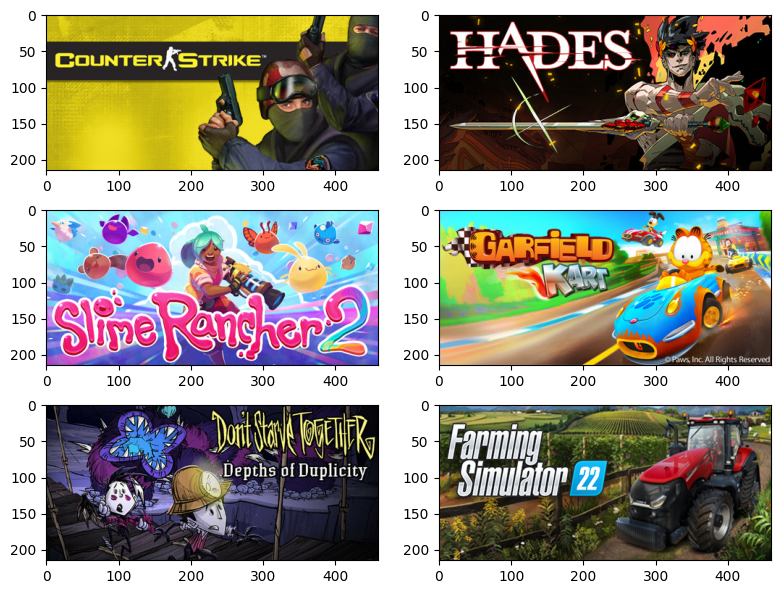

In [ ]:
# example_ids = [10, 1366540, 322330, 238460,]
example_ids = [10, 1145360, 1657630, 362930, 322330, 1248130]

# example_ids = np.random.choice(df.app_id, size=(6,))
show_images([images.get("img", id) for id in example_ids])

### Dominant Colors (K-Means Quantization)

In [ ]:
def find_top_colors(image_array, k):
    """Find k dominant colors using MiniBatchKMeans for speed."""
    kmeans = MiniBatchKMeans(n_clusters=k, n_init=3, batch_size=1000)  
    kmeans.fit(image_array)
    return kmeans.cluster_centers_

def replace_colors(image_array, top_colors):
    """Replace each pixel with the closest top color using cKDTree."""
    tree = cKDTree(top_colors)
    _, indices = tree.query(image_array)  # Find closest colors
    return top_colors[indices]

def rgb_to_lab(image_array):
    """Convert RGB image to LAB color space for better clustering."""
    return cv2.cvtColor(image_array.astype(np.uint8), cv2.COLOR_RGB2LAB).reshape(-1, 3)

def process_image(img, k):
    """Pipeline for a single image."""
    flat_lab = rgb_to_lab(img)
    top_colors = find_top_colors(flat_lab, k)
    return top_colors

In [ ]:
# Process images in parallel
k = 8
knn_colors = Parallel(n_jobs=-1, backend="loky")(
    delayed(process_image)(img, k) for img in images["img"])

images.add_column("knn", np.array(knn_colors))

Quantization: k=8


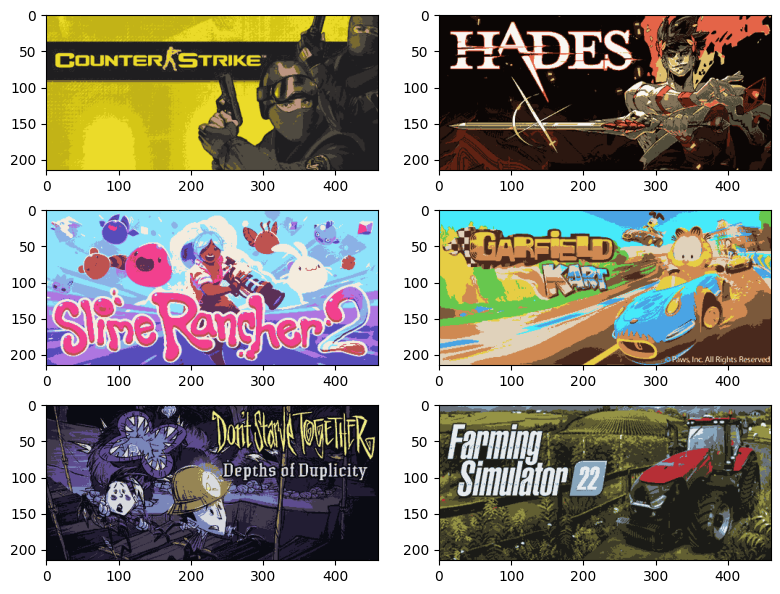

In [ ]:
knn_images = []

for img_idx in example_ids:
    img = images.get("img", img_idx)

    flat_lab = rgb_to_lab(img).reshape(-1, 3)
    top_colors = images.get("knn", img_idx)

    knn_image = replace_colors(flat_lab, top_colors)
    knn_image = knn_image.reshape(img.shape).astype(np.uint8)
    knn_image = cv2.cvtColor(knn_image, cv2.COLOR_LAB2RGB) # Back to RGB

    knn_images.append(knn_image)

print(f"Quantization: k={k}")
show_images(knn_images)

### Color Distribution (Histogram Analysis)

In [ ]:
# Compute color histograms for all images in the dataset
color_histograms = [[] for _ in range(3)]

for img in images["img"]:
    # Split channels
    r_hist = cv2.calcHist([img], [2], None, [256], [0, 256]).flatten()
    g_hist = cv2.calcHist([img], [1], None, [256], [0, 256]).flatten()
    b_hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
    
    # Normalize histograms (optional)
    r_hist /= r_hist.sum()
    g_hist /= g_hist.sum()
    b_hist /= b_hist.sum()
    
    # Store data
    color_histograms[0].append(r_hist)
    color_histograms[1].append(g_hist)
    color_histograms[2].append(b_hist)

# Convert lists to NumPy arrays
for i in range(3):
    color_histograms[i] = np.array(color_histograms[i])
color_histograms = np.array(color_histograms)
color_histograms = np.transpose(color_histograms, axes=[1, 0, 2])

images.add_column("hist", color_histograms)

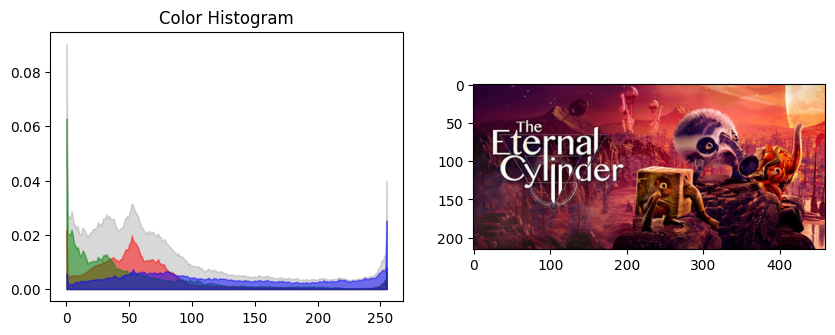

In [ ]:
img_idx = 2

y = color_histograms[img_idx]
x = np.arange(y.shape[1])
y_tot = y.sum(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

# plt.figure(figsize=(6.5, 3.5))
axes[0].fill_between(x, y_tot, color="gray", alpha=0.3, label="Total")
axes[0].fill_between(x, y[0], color="red", alpha=0.5, label="R")
axes[0].fill_between(x, y[1], color="green", alpha=0.5, label="G")
axes[0].fill_between(x, y[2], color="blue", alpha=0.5, label="B")
axes[0].set_title("Color Histogram")
# axes[0].legend()

axes[1].imshow(images["img"][img_idx])

plt.show()

### Structural Features (PCA)

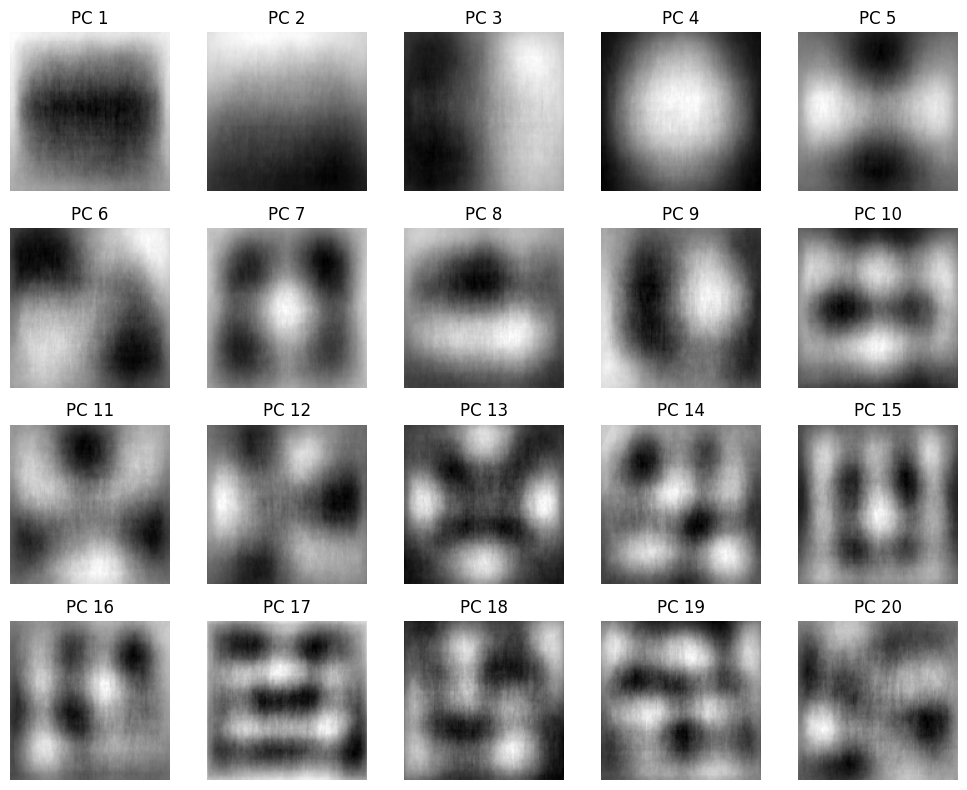

In [ ]:
EIG_SIZE = (128, 128)
EIG_COMPONENTS = 20

# Convert images to grayscale and flatten
eig = []

for img in images["img"]:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    resized = cv2.resize(gray, EIG_SIZE)          # Resize to fixed size
    flattened = resized.flatten()                 # Flatten into 1D vector
    eig.append(flattened)

# Stack all images into a matrix (each row is an image)
image_matrix = np.stack(eig)

# Apply PCA
pca = PCA(n_components=EIG_COMPONENTS)
pca.fit(image_matrix)

# Visualize the top principal components (Eigenimages)
fig, axes = plt.subplots(EIG_COMPONENTS // 5, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    if i >= EIG_COMPONENTS:
        break
    eigenimage = pca.components_[i].reshape(EIG_SIZE)  # Reshape back to image
    ax.imshow(eigenimage, cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Project images onto principal components
pca_features = pca.transform(image_matrix)

images.add_column("pca", pca_features)

### Signalling Colors

In [ ]:
def extract_signaling_color_proportion(color_histograms):
    """Extract proportion of signaling colors (bright red, yellow, orange) from histograms."""
    signaling_proportions = []

    for hist in color_histograms:
        red_hist, green_hist, blue_hist = hist  # Each image's RGB histograms

        # Define bright red & yellow regions in RGB histograms (sums are # of pixels in that range for that histogram)
        bright_red = np.sum(red_hist[200:256]) - np.sum(green_hist[200:256]) - np.sum(blue_hist[200:256])
        bright_yellow = np.sum(red_hist[200:256]) + np.sum(green_hist[200:256]) - np.sum(blue_hist[200:256])
        bright_orange = np.sum(red_hist[180:220]) + np.sum(green_hist[100:180]) - np.sum(blue_hist[0:100])

        # Normalize by total pixels to get proportion
        total_pixels = np.sum(red_hist) + np.sum(green_hist) + np.sum(blue_hist)
        signaling_score = (bright_red + bright_yellow + bright_orange) / total_pixels

        signaling_proportions.append(max(0, signaling_score))  # Ensure non-negative values

    return np.array(signaling_proportions)

# Extract signaling color proportions
signaling_scores = extract_signaling_color_proportion(color_histograms)

images.add_column("signal", signaling_scores)

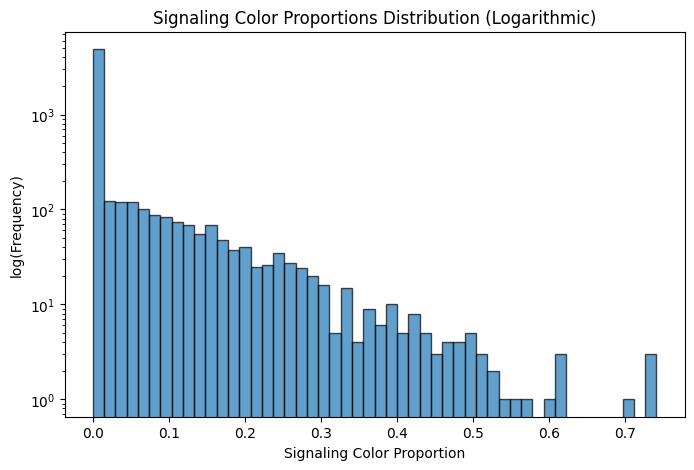

In [ ]:
plt.figure(figsize=(8, 5))

plt.hist(signaling_scores, bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Signaling Color Proportion")
plt.ylabel("log(Frequency)")
plt.title("Signaling Color Proportions Distribution (Logarithmic)")
plt.yscale("log")

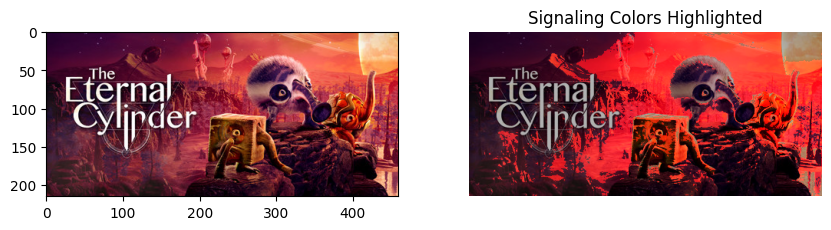

In [ ]:
def highlight_signaling_colors(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Define color ranges
    red_lower1, red_upper1 = np.array([0, 120, 120]), np.array([10, 255, 255])   # Red (low end)
    red_lower2, red_upper2 = np.array([170, 120, 120]), np.array([180, 255, 255]) # Red (high end)
    yellow_lower, yellow_upper = np.array([20, 100, 100]), np.array([35, 255, 255]) # Yellow
    orange_lower, orange_upper = np.array([10, 150, 100]), np.array([20, 255, 255]) # Orange

    # Create masks for each color
    mask_red = cv2.inRange(hsv, red_lower1, red_upper1) | cv2.inRange(hsv, red_lower2, red_upper2)
    mask_yellow = cv2.inRange(hsv, yellow_lower, yellow_upper)
    mask_orange = cv2.inRange(hsv, orange_lower, orange_upper)

    # Combine masks
    mask = mask_red | mask_yellow | mask_orange

    # Convert mask to 3-channel (Red overlay)
    mask_colored = np.zeros_like(image)  # Start with a black image
    mask_colored[:, :, 0] = mask  # Assign mask to Red channel (0: Red, 1: Green, 2: Blue)

    # Overlay mask on the original image
    overlayed = cv2.addWeighted(image, 0.7, mask_colored, 0.5, 0)

    return overlayed

image = images["img"][2]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Apply the overlay function
highlighted_image = highlight_signaling_colors(image)

# Show the result
axes[0].imshow(image)
axes[1].imshow(highlighted_image)
plt.axis("off")
plt.title("Signaling Colors Highlighted")
plt.show()

---

## Tags

### Encoding

In [ ]:
# Group tags by app_id
grouped_df = tags.groupby("app_id")["tag"].apply(list).reset_index()

# Apply MultiLabelBinarizer
mlb = MultiLabelBinarizer()
tag_matrix = mlb.fit_transform(grouped_df["tag"])

# Convert to DataFrame
tag_df = pd.DataFrame(tag_matrix, columns=mlb.classes_, index=grouped_df["app_id"])

### Top Tag Co-Occurence

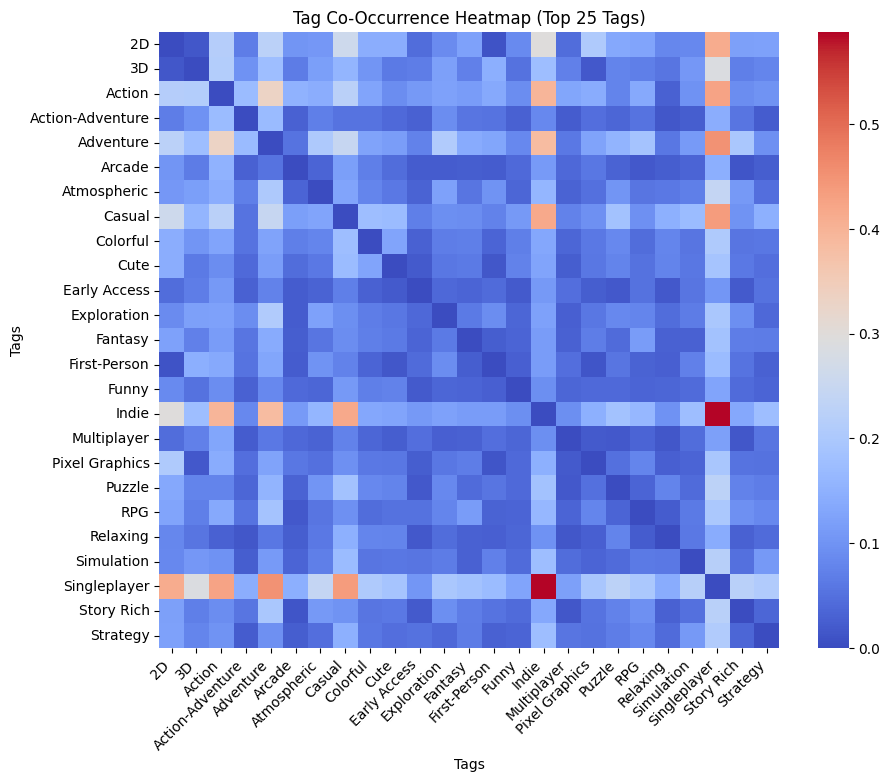

In [ ]:
top_n = 25
tag_counts = tags["tag"].value_counts()
top_tags = tag_counts.nlargest(top_n).index

# Filter dataset to include only top tags
filtered_df = tags[tags["tag"].isin(top_tags)]

# Compute matrix
co_mat = pd.crosstab(filtered_df["app_id"], filtered_df["tag"])
co_mat = co_mat.T.dot(co_mat)

# Normalize
co_mat = co_mat / co_mat.max().max()

# Zero out diagonal
np.fill_diagonal(co_mat.values, 0.0)

plt.figure(figsize=(10, 8))
sns.heatmap(co_mat, cmap="coolwarm", annot=False, xticklabels=True, yticklabels=True)
plt.title("Tag Co-Occurrence Heatmap (Top {} Tags)".format(top_n))
plt.xlabel("Tags")
plt.ylabel("Tags")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

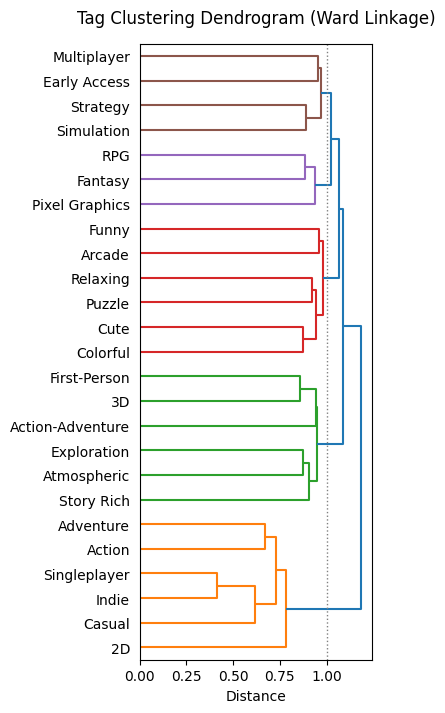

In [ ]:
# Convert similarity to distance
distance_matrix = 1 - co_mat

# Convert to condensed format (required for linkage)
condensed_dist = squareform(distance_matrix, checks=False)

# Perform clustering
linkage_matrix = linkage(condensed_dist, method='ward')

plt.figure(figsize=(3, 8))
threshold = 1.0
dendrogram(linkage_matrix, labels=co_mat.index, leaf_rotation=0, orientation="right", color_threshold=threshold)
plt.axvline(threshold, color="gray", ls=":", linewidth=1)
plt.title("Tag Clustering Dendrogram (Ward Linkage)", y=1.02)
plt.xlabel("Distance")
plt.show()

### Tag Combinations

In [ ]:
# Generate tag pairs
tag_pairs = []
for tags in grouped_df["tag"]:
    tag_pairs.extend(combinations(tags, 2))

# Count frequency of each tag pair
tag_pair_counts = Counter(tag_pairs)

# Convert to DataFrame
tag_pair_df = pd.DataFrame(tag_pair_counts.items(), columns=["TagPair", "Count"]).sort_values(by="Count", ascending=False)

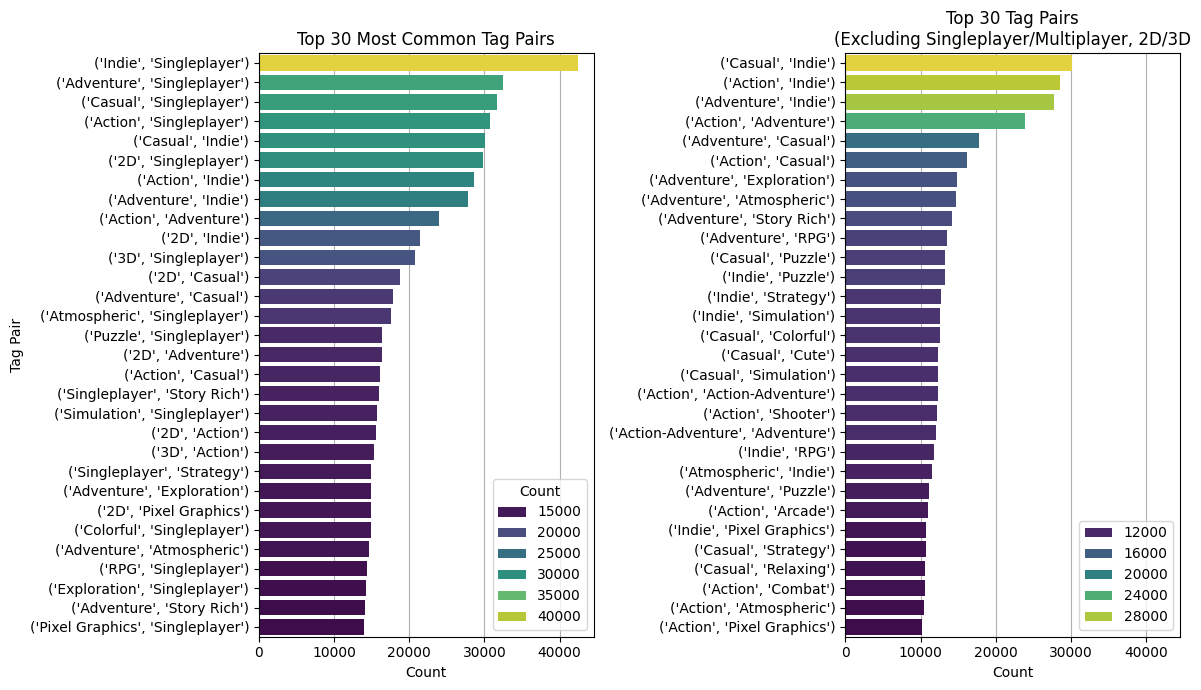

In [ ]:
# Define tags to exclude
exclude_tags = {"Singleplayer", "2D", "3D", "Multiplayer"}

# Get the top 30 tag pairs
df_top = tag_pair_df.nlargest(30, "Count")
df_top["TagPair"] = df_top["TagPair"].astype(str)

# Filter out tag pairs containing excluded tags
df_filtered = tag_pair_df[~tag_pair_df["TagPair"].apply(lambda x: any(tag in x for tag in exclude_tags))]

# Ensure the filtered dataset also contains 30 entries
df_filtered_top = df_filtered.nlargest(30, "Count")
df_filtered_top["TagPair"] = df_filtered_top["TagPair"].astype(str)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 7), sharex=True)

# Plot all top tag pairs
sns.barplot(y=df_top["TagPair"], x=df_top["Count"], hue=df_top["Count"], palette="viridis", ax=axes[0])
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Tag Pair")
axes[0].set_title("Top 30 Most Common Tag Pairs")
axes[0].grid(axis="x")
axes[0].set_axisbelow(True)

# Plot filtered tag pairs (ensuring it also contains 30 entries)
sns.barplot(y=df_filtered_top["TagPair"], x=df_filtered_top["Count"],
            hue=df_filtered_top["Count"], palette="viridis", ax=axes[1])
axes[1].set_xlabel("Count")
axes[1].set_ylabel(None)
axes[1].set_title("Top 30 Tag Pairs\n(Excluding Singleplayer/Multiplayer, 2D/3D")
axes[1].grid(axis="x")
axes[1].set_axisbelow(True)
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


C:\Users\eric\AppData\Local\Temp\ipykernel_32700\4087990976.py:18: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:Blue'` for the same effect.

  sns.barplot(y=df["Tag"], x=df["Count"], hue=df["Count"], color="Blue")


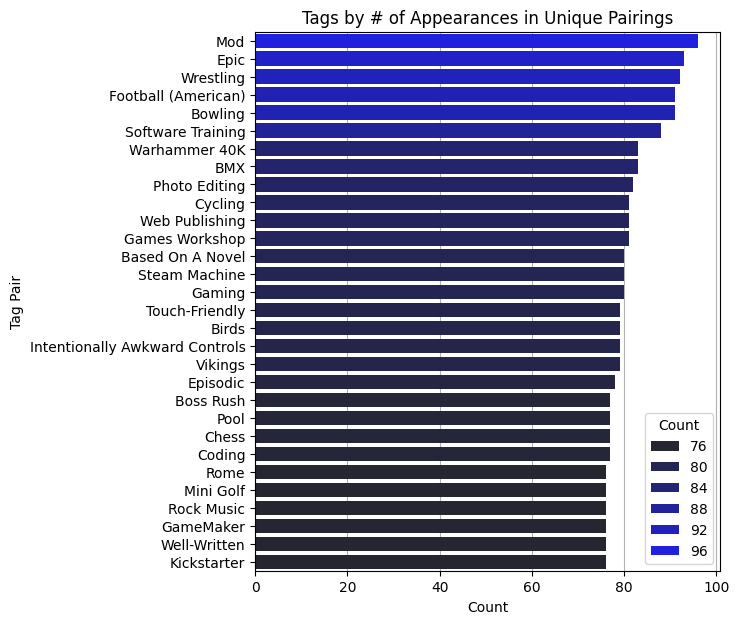

In [ ]:
# Filter rare tag pairs
rare_pairs = [pair for pair, count in tag_pair_counts.items() if count <= 1]

# Extract individual tags from rare pairs
uncommon_tags = [tag for pair in rare_pairs for tag in pair]

# Count occurrences of each tag in these rare pairs
uncommon_tag_counts = Counter(uncommon_tags)

# Convert to DataFrame and show the most frequently occurring "rare tags"
uncommon_tag_df = pd.DataFrame(
    uncommon_tag_counts.items(), columns=["Tag", "Count"]).sort_values(by="Count", ascending=False)

df = uncommon_tag_df.nlargest(30, "Count")

# Plot
plt.figure(figsize=(6, 7))
sns.barplot(y=df["Tag"], x=df["Count"], hue=df["Count"], color="Blue")
plt.xlabel("Count")
plt.ylabel("Tag Pair")
plt.title("Tags by # of Appearances in Unique Pairings")
plt.gca().set_axisbelow(True)
plt.grid(axis="x")
plt.show()

### Relationship to Image Features

In [ ]:
# Map histogram features to RGB labels
def interpret_hist_feature(hist_index):
    channel = hist_index // 256  # 0=Red, 1=Green, 2=Blue
    bin_index = hist_index % 256
    channels = ["red", "green", "blue"]
    return f"{channels[channel]}_{bin_index}"

# Count how many games have each tag and keep only frequent
min_games = 50
tag_counts = tag_df.sum()
common_tags = tag_counts[tag_counts >= min_games].index

# Filter tag matrix to only include common tags
filtered_tag_df = tag_df[common_tags]

# Convert histogram to DataFrame (Flatten RGB histograms)
hist_flat = images["hist"].reshape(6174, -1)  # Shape becomes (6174, 768)
hist_df = pd.DataFrame(hist_flat, index=list(images.map.keys()), columns=[f"hist_{i}" for i in range(hist_flat.shape[1])])

# Convert PCA features to DataFrame
pca_df = pd.DataFrame(images["pca"], index=list(images.map.keys()), columns=[f"pca_{i}" for i in range(images["pca"].shape[1])])

# Rename histogram feature columns
hist_feature_names = [interpret_hist_feature(i) for i in range(768)]
hist_df.columns = hist_feature_names

# Compute correlation matrix again with meaningful labels
combined_df = filtered_tag_df.merge(hist_df, left_index=True, right_index=True).merge(pca_df, left_index=True, right_index=True)
correlation_matrix = combined_df.corr("spearman")

# Extract correlations of tags with image features
tag_image_corr = correlation_matrix.loc[filtered_tag_df.columns, hist_feature_names + list(pca_df.columns)]

# Show top readable correlations
top_tag_correlations = tag_image_corr.unstack().sort_values(key=abs, ascending=False).head(30)

top_tag_correlations

pca_0      Cute      0.267180
blue_249   Cute      0.266336
blue_251   Cute      0.264666
blue_248   Cute      0.264046
blue_247   Cute      0.262608
blue_250   Cute      0.261045
blue_246   Cute      0.256060
blue_252   Cute      0.255963
blue_245   Cute      0.253150
blue_244   Cute      0.250434
pca_0      Horror   -0.245502
blue_253   Cute      0.244366
blue_243   Cute      0.242262
blue_255   Cute      0.241426
blue_248   Anime     0.239777
blue_244   Anime     0.238841
blue_247   Anime     0.238818
blue_245   Anime     0.238324
blue_242   Cute      0.236513
green_13   Cute     -0.236454
blue_246   Anime     0.236125
blue_249   Anime     0.235281
green_148  Horror   -0.235022
green_15   Cute     -0.234836
red_215    Anime     0.234665
green_14   Cute     -0.234646
green_246  Anime     0.234531
green_149  Horror   -0.233841
green_147  Horror   -0.233836
red_217    Anime     0.233792
dtype: float64

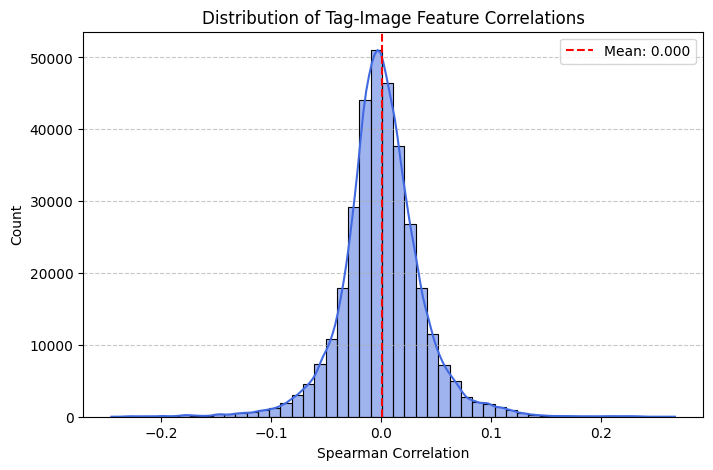

In [ ]:
# Flatten correlation values into a list for distribution analysis
corr_values = tag_image_corr.values.flatten()

corr_values = corr_values[~pd.isna(corr_values)]

plt.figure(figsize=(8, 5))
sns.histplot(corr_values, bins=50, kde=True, color="royalblue")
plt.xlabel("Spearman Correlation")
plt.ylabel("Count")
plt.title("Distribution of Tag-Image Feature Correlations")
plt.axvline(x=corr_values.mean(), color="red", linestyle="dashed", label=f"Mean: {corr_values.mean():.3f}")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

---

## Titles and Descriptions

### Embedding

In [ ]:
top_games = top_ids.merge(games, how="left", on="app_id")
top_desc = top_ids.merge(desc, how="left", on="app_id")

In [ ]:
# Load model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device="cpu")

# Encode text
title_emb = model.encode(top_games.name, device="cpu")
desc_emb = model.encode(top_desc.summary, device="cpu")

In [ ]:
# Create column names
title_columns = [f"title_{i}" for i in range(384)]
description_columns = [f"description_{i}" for i in range(384)]

# Create DataFrame
embedding_df = pd.DataFrame(
    np.hstack((title_emb, desc_emb)),
    index=top_games.app_id,
    columns=title_columns + description_columns
)
embedding_df = embedding_df.reset_index()

embedding_df

,app_id,title_0,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9,title_10,title_11,title_12,title_13,title_14,title_15,title_16,title_17,title_18,title_19,title_20,title_21,title_22,title_23,title_24,title_25,title_26,title_27,title_28,title_29,title_30,title_31,title_32,title_33,title_34,title_35,title_36,title_37,title_38,...,description_344,description_345,description_346,description_347,description_348,description_349,description_350,description_351,description_352,description_353,description_354,description_355,description_356,description_357,description_358,description_359,description_360,description_361,description_362,description_363,description_364,description_365,description_366,description_367,description_368,description_369,description_370,description_371,description_372,description_373,description_374,description_375,description_376,description_377,description_378,description_379,description_380,description_381,description_382,description_383
0,1126290,-0.050256,-0.020565,-0.019488,0.082947,0.031099,0.137367,0.084347,0.008495,0.085504,0.007394,-0.021372,-0.050072,0.029706,-0.019087,-0.046914,-0.001339,-0.035792,0.002041,-0.018701,-0.057855,0.017078,0.027031,-0.022506,0.005388,0.071258,0.036707,0.020262,0.040104,-0.061890,-0.101536,0.011819,0.032519,-0.062775,-0.003341,-0.035496,0.035975,-0.074499,-0.016353,-0.020465,...,-0.062438,-0.035389,-0.002878,-0.034202,-0.085861,-0.028155,0.021664,0.029581,0.038756,-0.011882,0.066591,-0.027927,-0.027178,-0.021782,-0.084686,0.021006,-0.077002,-0.035548,0.134260,0.072858,0.068505,0.076444,0.148348,-0.089417,0.026139,0.090691,-0.053140,-0.008252,0.070663,0.039937,-0.005694,-0.023801,-0.032999,0.051731,0.025505,0.154382,0.033559,-0.021359,-0.091419,-0.062813
1,2643960,-0.129749,-0.016219,-0.024965,-0.035633,0.061787,0.074762,0.055821,0.019080,0.029133,0.049099,0.010173,-0.085619,0.013242,0.004432,-0.018575,0.060343,0.056136,0.050602,0.037946,-0.005183,-0.089385,0.062085,0.035681,0.052026,-0.005667,-0.004604,0.019282,0.065813,0.048791,-0.101744,-0.004838,-0.057130,-0.069643,0.018799,0.009376,-0.058799,-0.035790,-0.063535,-0.074698,...,-0.027874,-0.023825,0.038531,-0.004128,0.022921,0.081457,-0.035837,0.034906,-0.063615,0.023397,0.000766,0.087451,0.024504,-0.026148,-0.042488,0.049248,-0.048652,-0.061163,0.095617,0.054490,-0.098984,0.008726,-0.019610,-0.153043,0.001581,-0.091637,0.023777,0.056675,-0.044965,0.061620,0.014144,0.090016,0.037356,0.051876,-0.021600,0.001736,0.064799,-0.103477,-0.050867,-0.042309
2,865680,-0.078871,0.117474,-0.048866,-0.007239,-0.028899,0.016252,0.006428,-0.006294,0.081680,-0.090255,0.005317,0.009238,-0.020015,0.035297,-0.089230,-0.041639,-0.028837,0.039084,-0.009442,-0.004684,-0.017383,0.055165,0.020898,0.039403,-0.046754,0.098341,-0.008123,0.096652,0.113181,-0.083847,-0.086796,0.025357,-0.124055,-0.029547,0.027347,-0.051698,-0.027876,0.034825,-0.038354,...,-0.017720,-0.022112,-0.006895,-0.053887,0.029789,0.074305,-0.014454,0.020247,-0.055822,0.097768,-0.017759,0.037169,-0.082384,0.000961,0.032016,0.046820,0.044284,0.073274,-0.023368,0.004026,-0.018615,-0.022807,0.009115,-0.012798,0.024685,0.010077,-0.049240,-0.009595,0.049877,0.062324,0.039589,-0.002367,-0.019732,0.027694,-0.046915,0.093789,0.054223,0.006286,0.008926,0.009239
3,22500,-0.056642,0.014319,-0.071488,-0.033871,0.047916,-0.060539,0.092185,0.081105,-0.034350,-0.015561,0.014825,-0.100945,-0.059514,0.053932,-0.077393,0.043069,0.047092,-0.026616,0.008749,-0.072365,-0.034241,0.010635,-0.047091,-0.015529,0.030930,0.038998,-0.069360,0.015068,0.071405,-0.030792,0.128954,0.031555,-0.002504,0.038158,0.083661,-0.023545,0.005115,0.052067,-0.003304,...,-0.051580,0.006402,0.071246,-0.035632,0.049791,0.007613,0.106455,-0.004453,0.034147,0.091146,-0.015209,-0.011504,-0.049313,0.029931,-0.044708,-0.047738,-0.068548,0.044864,-0.002811,-0.043571,-0.064919,-0.039843,-0.080146,-0.041508,0.083607,-0.077277,-0.006563,0.023201,-0.002312,0.027251,0.066785,0.096210,0.026598,0.077799,0.003258,0

### Images Correlation

In [ ]:
# Concatenate color histogram and PCA features
visual_features_df = pd.concat([hist_df, pca_df], axis=1)

# Normalize visual features
scaler = StandardScaler()
visual_features_scaled = scaler.fit_transform(visual_features_df)

# Convert back to DataFrame
visual_features_df = pd.DataFrame(visual_features_scaled, index=visual_features_df.index, columns=visual_features_df.columns)

In [ ]:
# Compute cosine similarity for visuals
visual_sim_matrix = cosine_similarity(visual_features_df.values)

# Compute cosine similarity for text embeddings
text_sim_matrix = cosine_similarity(desc_emb)

# Flatten both similarity matrices
visual_sim_flat = visual_sim_matrix.flatten()
text_sim_flat = text_sim_matrix.flatten()

# Compute Spearman correlation
correlation, _ = spearmanr(text_sim_flat, visual_sim_flat)

print(f"Spearman correlation between text similarity and visual similarity: {correlation:.3f}")

Spearman correlation between text similarity and visual similarity: 0.024


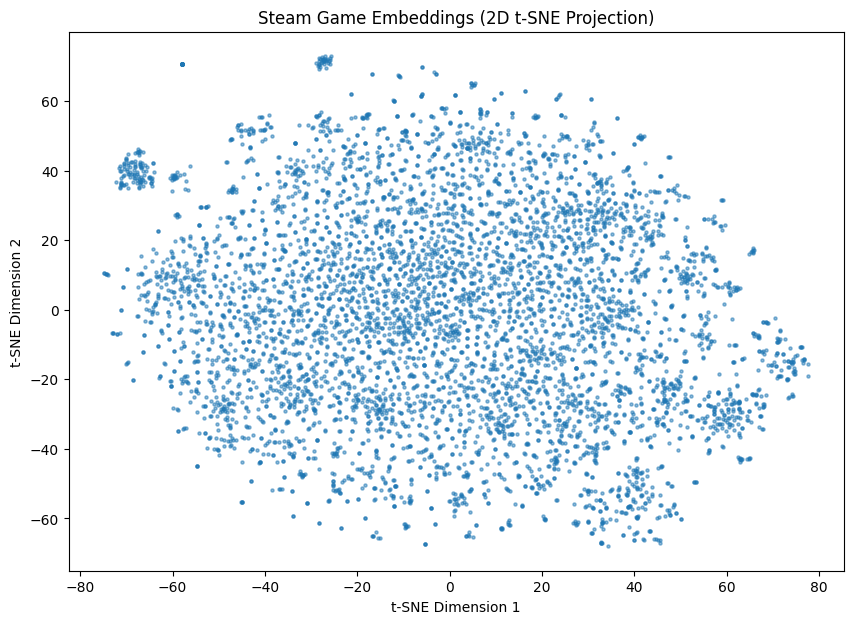

In [ ]:
reducer = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = reducer.fit_transform(desc_emb)

plt.figure(figsize=(10, 7))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=5, alpha=0.5)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("Steam Game Embeddings (2D t-SNE Projection)")
plt.show()

---

## Concurrent Users EDA

### Relationship to Image Features

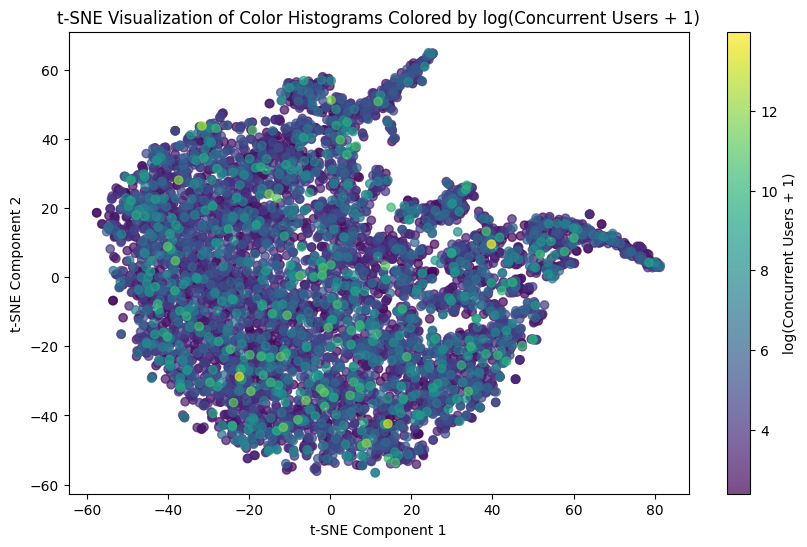

In [ ]:
def plot_histogram_tsne_users(user_counts):
    """t-SNE visualization of color histograms with color mapping based user count"""
    hist_vectors = []
    user_values = []

    for app_id in images.map.keys():
        hist = images.get("hist", app_id).flatten()  # Flatten histogram vector
        
        if app_id in user_counts:  # Ensure data exists for this game
            hist_vectors.append(hist)
            user_values.append(user_counts[app_id])  # Continuous feature (e.g., user count)

    hist_vectors = np.array(hist_vectors)
    user_values = np.array(user_values)

    # Reduce to 2D using t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings = tsne.fit_transform(hist_vectors)

    df = pd.DataFrame({
        "x": embeddings[:, 0],
        "y": embeddings[:, 1],
        "users": user_values,
    })

    # Scatter plot with color gradient based on users
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df["x"], df["y"], c=df["users"], cmap="viridis", alpha=0.7)
    plt.colorbar(scatter, label="log(Concurrent Users + 1)")
    plt.title("t-SNE Visualization of Color Histograms Colored by log(Concurrent Users + 1)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

# Convert log user counts to a dictionary
user_counts = spy.groupby("app_id")["concurrent_users_yesterday"].apply(lambda x: np.log1p(x).iloc[0]).to_dict()

plot_histogram_tsne_users(user_counts)

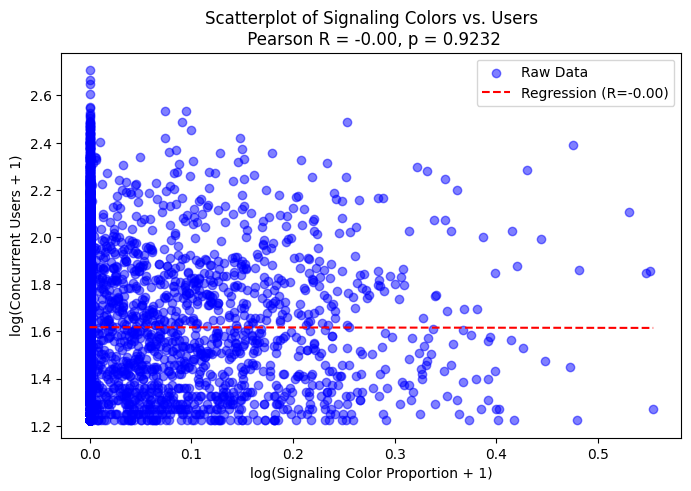

In [ ]:
user_values = np.array([user_counts.get(app_id, 0) for app_id in images.map.keys()])  # Match order

df = pd.DataFrame({"signaling": signaling_scores, "log_signaling": np.log1p(signaling_scores),
                   "log_users": np.log1p(user_values)})

# Compute regression on raw (non-binned) data
slope_raw, intercept_raw, r_value_raw, p_value_raw, std_err_raw = linregress(df["log_signaling"], df["log_users"])

# Generate regression line for raw data
x_range = np.linspace(df["log_signaling"].min(), df["log_signaling"].max(), 100)
y_fit_raw = slope_raw * x_range + intercept_raw

# Compute Pearson correlation on raw values (not binned)
pearson_corr, pearson_p = pearsonr(df["log_signaling"], df["log_users"])

# Scatter plot of raw data with regression line
plt.figure(figsize=(8, 5))
plt.scatter(df["log_signaling"], df["log_users"], alpha=0.5, color="blue", label="Raw Data")
plt.plot(x_range, y_fit_raw, color="red", linestyle="--", label=f"Regression (R={r_value_raw:.2f})")

# Labels and title
plt.xlabel("log(Signaling Color Proportion + 1)")
plt.ylabel("log(Concurrent Users + 1)")
plt.title(f"Scatterplot of Signaling Colors vs. Users\n Pearson R = {pearson_corr:.2f}, p = {pearson_p:.4f}")
plt.legend()
plt.show()

---

## Concurrent Users Prediction

### Wrangling and Cleaning

***Dates***

In [ ]:
games_df = games

games_df["release_date"] = pd.to_datetime(games_df["release_date"], errors="coerce")
games_df["date_missing"] = games_df["release_date"].isna().astype(int)

games_df["release_year"] = games_df["release_date"].dt.year.fillna(-1).astype(int)
games_df["release_month"] = games_df["release_date"].dt.month.fillna(-1).astype(int)
games_df["release_day"] = games_df["release_date"].dt.day.fillna(-1).astype(int)

***Price (Convert to Euros)***

In [ ]:
# Safe regex extraction function
def extract_price_currency(price_str, is_free):
    if is_free == 1 or pd.isna(price_str):
        return 0.0, "FREE"
    
    price_match = re.search(r"'final':\s*(\d+)", price_str)
    currency_match = re.search(r"'currency':\s*'(\w+)'", price_str)

    price = int(price_match.group(1)) / 100 if price_match else 0.0  # Convert cents to float
    currency = currency_match.group(1) if currency_match else "UNKNOWN"

    return price, currency

# Apply function to extract price and currency
games_df[['price', 'currency']] = games_df.apply(
    lambda row: pd.Series(extract_price_currency(row["price_overview"], row["is_free"])), axis=1)

EXCHANGE_RATES = {
    "USD": 0.92,  # 1 USD = 0.92 EUR
    "GBP": 1.17,  # 1 GBP = 1.17 EUR
    "RUB": 0.010  # 1 RUB = 0.010 EUR
}

def convert_price(row):
    if row["currency"] == "FREE":
        return 0.0
    elif row["currency"] in EXCHANGE_RATES:
        return row["price"] * EXCHANGE_RATES[row["currency"]]
    return row["price"]  # Keep EUR prices unchanged

# Apply conversion
games_df["price_euros"] = games_df.apply(convert_price, axis=1)

# Filter dataset to keep only EUR, FREE, and converted currencies
valid_currencies = {"EUR", "FREE"}
games_df = games_df[games_df["currency"].isin(valid_currencies | set(EXCHANGE_RATES.keys()))]

games_df = games_df.drop(columns=["currency", "price"])

***Construct DataFrame***

In [ ]:
features = ["app_id", "price_euros", "date_missing", "release_year", "release_month", "release_day"]

df = top_ids.merge(games_df, how="left", on="app_id")

df = df.loc[:, features]

df = spy.loc[:, ["app_id", "concurrent_users_yesterday"]].merge(df, on="app_id", how="right")

In [ ]:
df = df.merge(visual_features_df.reset_index().rename({"index": "app_id"}, axis=1),
              how="left", on="app_id")
df = df.merge(embedding_df, how="left", on="app_id")

df = df.dropna()

### Prediction

In [ ]:
X = df.drop(columns=["concurrent_users_yesterday"])
X = X.drop(columns=["app_id"])

y = df["concurrent_users_yesterday"]

In [ ]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform feature seleciton with lasso CV
# lasso = ElasticNetCV(cv=5, alphas=np.logspace(-4, 1, 50), max_iter=10_000).fit(X_train, y_train)
# selected_features = X.columns[lasso.coef_ != 0]
# print(selected_features)
# X_train = X_train[:, lasso.coef_ != 0]
# X_test = X_test[:, lasso.coef_ != 0]

# Select top 50 most informative features
selector = SelectKBest(mutual_info_regression, k=50)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Train SVM
C_value = 1.0
reg = SVR(kernel="linear", C=C_value)#, epsilon=0.1)
reg.fit(X_train_selected, y_train)

# Predict on test set
y_pred = reg.predict(X_test_selected)

In [ ]:
# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-Squared: {r2:.4f}")

# Get feature importance (absolute value of coefficients)
feature_importance = np.abs(reg.coef_).flatten()
feature_names = X.columns

# Display top features
top_n = 10
top_features = sorted(zip(feature_importance, feature_names), reverse=True)[:top_n]
print("Top Features:", top_features)

MAE: 757.2856
RMSE: 5488.0581
R-Squared: -0.0167
Top Features: [(np.float64(17.661585701731124), 'price_euros'), (np.float64(13.92018611171944), 'release_year'), (np.float64(10.7799566774835), 'date_missing'), (np.float64(3.210641505269979), 'release_day'), (np.float64(0.3470923186132029), 'release_month')]


---

## Review Score Prediction

### With Image and Text Embeddings

***Wrangling***

In [ ]:
reviews_df = top_ids.merge(reviews, on="app_id", how="left")

# Filter out games without enough reviews for a score
reviews_df = reviews_df[reviews_df["total"] >= 10.0]

reviews_df = reviews_df.loc[:, ["app_id", "review_score"]]

In [ ]:
features = ["app_id", "price_euros", "date_missing", "release_year", "release_month", "release_day"]

df = top_ids.merge(games_df.loc[:, features], how="left", on="app_id")

df = reviews_df.merge(df, on="app_id", how="right")

# Add image, text, and tag features
df = df.merge(visual_features_df.reset_index().rename({"index": "app_id"}, axis=1),
              how="left", on="app_id")
df = df.merge(embedding_df, how="left", on="app_id")
df = df.merge(tag_df, how="left", on="app_id")

df = df.dropna()
df

,app_id,review_score,price_euros,date_missing,release_year,release_month,release_day,red_0,red_1,red_2,red_3,red_4,red_5,red_6,red_7,red_8,red_9,red_10,red_11,red_12,red_13,red_14,red_15,red_16,red_17,red_18,red_19,red_20,red_21,red_22,red_23,red_24,red_25,red_26,red_27,red_28,red_29,red_30,red_31,red_32,...,Transhumanism,Transportation,Trivia,Turn-Based,Turn-Based Combat,Turn-Based Strategy,Turn-Based Tactics,Tutorial,Twin Stick Shooter,Typing,Underground,Underwater,Unforgiving,Utilities,VR,Vampire,Vehicular Combat,Video Production,Vikings,Villain Protagonist,Violent,Visual Novel,Voice Control,Volleyball,Voxel,Walking Simulator,War,Wargame,Warhammer 40K,Web Publishing,Well-Written,Werewolves,Western,Wholesome,Word Game,World War I,World War II,Wrestling,Zombies,eSports
0,1126290,8.0,2.99,0.0,2019.0,9.0,30.0,-0.464894,-0.363463,-0.481515,-0.500198,-0.548303,-0.581489,-0.576065,-0.526898,-0.475465,-0.679049,-0.440653,-0.660978,-0.658884,-0.699919,-0.513113,-0.535460,-0.606239,-0.494318,-0.543213,-0.460723,-0.642711,-0.755035,-0.777364,-0.860924,-0.417593,-0.749312,-0.676299,-0.757675,-0.756237,-0.794567,-0.561122,-0.508296,-0.788261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2643960,7.0,4.99,0.0,2024.0,6.0,21.0,-0.260200,-0.246976,-0.224925,-0.261070,-0.244275,-0.234289,-0.233043,-0.214855,-0.129586,-0.188726,-0.123749,-0.217086,-0.191427,-0.174549,-0.199606,-0.159881,-0.222999,-0.174566,-0.149396,-0.055992,-0.100623,-0.058825,-0.080319,-0.109595,-0.056224,-0.054744,-0.037457,-0.020777,0.038353,0.031659,0.020110,0.049909,0.003251,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,865680,8.0,7.49,0.0,2022.0,10.0,13.0,-0.264751,-0.225730,-0.224409,-0.227687,-0.189724,-0.177520,-0.191232,-0.137241,-0.133257,-0.133776,-0.132496,-0.167070,-0.102736,-0.131981,-0.090152,-0.042151,-0.036987,0.003918,0.029066,0.062709,0.076035,0.220631,0.188346,0.313470,0.101593,0.293148,0.246844,0.334743,0.325648,0.501333,0.318387,0.325278,0.582441,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22500,8.0,3.44,0.0,2009.0,2.0,11.0,-0.450313,-0.359068,-0.469124,-0.487935,-0.531574,-0.568325,-0.563266,-0.511058,-0.458575,-0.655801,-0.415758,-0.616172,-0.631755,-0.660712,-0.481840,-0.502296,-0.567915,-0.457862,-0.517473,-0.420679,-0.579114,-0.685778,-0.696888,-0.743485,-0.371859,-0.642268,-0.602715,-0.680107,-0.657884,-0.697196,-0.502896,-0.442021,-0.630825,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,880950,9.0,20.99,0.0,2018.0,9.0,21.0,-0.460622,-0.361998,-0.477901,-0.499517,-0.543939,-0.578198,-0.574359,-0.526898,-0.476934,-0.674822,-0.439307,-0.660978,-0.663058,-0.705520,-0.518585,-0.531314,-0.609978,-0.495837,-0.554367,-0.459293,-0.630598,-0.750175,-0.750126,-0.843945,-0.415661,-0.732282,-0.678529,-0.756382,-0.731649,-0.791703,-0.550907,-0.498962,-0.690044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6169,1172470,5.0,0.00,1.0,-1.0,-1.0,-1.0,-0.433502,-0.348445,-0.437632,-0.427983,-0.471932,-0.477000,-0.463431,-0.427108,-0.375593,-0.531107,-0.349148,-0.498426,-0.510717,-0.512847,-0.369259,-0.400318,-0.431444,-0.360645,-0.388775,-0.296971,-0.40144

***Prediction***

In [ ]:
X = df.drop(columns=["review_score"])
X = X.drop(columns=["app_id"])

y = df["review_score"]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform feature seleciton with lasso CV
elastic = ElasticNetCV(cv=5, max_iter=10_000).fit(X_train, y_train)
mask = elastic.coef_ != 0
selected_features = X.columns[mask]
print(selected_features)
X_train = X_train.iloc[:, mask]
X_test = X_test.iloc[:, mask]

reg = RandomForestRegressor(n_estimators=200, max_depth=5)#, epsilon=0.1)
reg.fit(X_train, y_train)

# Predict on test set
y_pred = reg.predict(X_test)

Index(['price_euros', 'release_year', 'release_month', 'release_day', 'red_20',
       'red_24', 'red_29', 'red_35', 'red_88', 'red_92', 'red_99', 'red_111',
       'red_126', 'red_130', 'red_150', 'red_160', 'red_168', 'red_177',
       'red_188', 'red_213', 'red_216', 'red_230', 'green_31', 'green_34',
       'green_38', 'green_73', 'green_98', 'green_112', 'green_130',
       'green_139', 'green_153', 'green_168', 'green_176', 'green_193',
       'green_198', 'green_212', 'green_223', 'green_224', 'green_237',
       'green_248', 'blue_12', 'blue_17', 'blue_46', 'blue_51', 'blue_60',
       'blue_75', 'blue_81', 'blue_90', 'blue_115', 'blue_128', 'blue_133',
       'blue_134', 'blue_150', 'blue_175', 'blue_185', 'blue_202', 'blue_225',
       'blue_228', 'blue_236', 'blue_252', 'blue_254', 'pca_1', 'pca_2',
       'pca_7', 'pca_8', '2D', 'Atmospheric', 'Colorful', 'Cute', 'Difficult',
       'Free to Play', 'Funny', 'Great Soundtrack', 'Indie',
       'Massively Multiplayer', 'Multi

In [ ]:
# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-Squared: {r2:.4f}")

MAE: 0.9807
RMSE: 1.1726
R-Squared: 0.1609


In [ ]:
perm_importance = permutation_importance(reg, X_test, y_test, n_repeats=30, random_state=42)
importances = perm_importance.importances_mean
p_values = (perm_importance.importances > 0).mean(axis=1)

# Display feature importance and corresponding p-values
for i, (imp, p_val) in enumerate(zip(importances, p_values)):
    print(f"{selected_features[i]}: Importance = {imp:.4f}, p-value = {p_val:.4f}")

feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances,
    'P-Value': p_values
}).sort_values(by='Importance', ascending=False)

feature_importance_df.sort_values("P-Value").head(30)

price_euros: Importance = 0.0977, p-value = 1.0000
release_year: Importance = 0.0022, p-value = 1.0000
release_month: Importance = -0.0001, p-value = 0.1667
release_day: Importance = -0.0000, p-value = 0.4667
red_20: Importance = 0.0031, p-value = 1.0000
red_24: Importance = 0.0003, p-value = 0.9000
red_29: Importance = 0.0001, p-value = 0.7667
red_35: Importance = 0.0005, p-value = 0.9667
red_88: Importance = 0.0003, p-value = 0.9667
red_92: Importance = -0.0004, p-value = 0.0000
red_99: Importance = -0.0007, p-value = 0.0667
red_111: Importance = 0.0000, p-value = 0.6000
red_126: Importance = -0.0000, p-value = 0.4667
red_130: Importance = -0.0004, p-value = 0.0000
red_150: Importance = 0.0001, p-value = 0.9333
red_160: Importance = -0.0000, p-value = 0.4000
red_168: Importance = -0.0000, p-value = 0.3000
red_177: Importance = -0.0001, p-value = 0.0333
red_188: Importance = -0.0001, p-value = 0.2667
red_213: Importance = 0.0000, p-value = 0.6667
red_216: Importance = 0.0003, p-value 

,Feature,Importance,P-Value
9,red_92,-0.000435,0.000000
13,red_130,-0.000440,0.000000
46,blue_81,-0.000405,0.033333
17,red_177,-0.000146,0.033333
24,green_38,-0.000098,0.066667
10,red_99,-0.000663,0.066667
64,pca_8,-0.000380,0.066667
30,green_153,-0.000168,0.100000
47,blue_90,-0.000335,0.100000
2,release_month,-0.000108,0.166667


### Without Image and Embedded Text

In [ ]:
reviews_df = reviews

# Filter out games without enough reviews for a score
reviews_df = reviews_df[reviews_df["total"] >= 10.0]

reviews_df = reviews_df.loc[:, ["app_id", "review_score"]]

In [ ]:
features = ["app_id", "price_euros", "date_missing", "release_year", "release_month", "release_day"]

df = games_df.loc[:, features]

df = reviews_df.merge(df, on="app_id", how="right")

# Add tag features
df = df.merge(tag_df, how="left", on="app_id")

df = df.dropna()
df

,app_id,review_score,price_euros,date_missing,release_year,release_month,release_day,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,3D Vision,4 Player Local,4X,6DOF,8-bit Music,ATV,Abstract,Action,Action RPG,Action RTS,Action Roguelike,Action-Adventure,Addictive,Adventure,Agriculture,Aliens,Alternate History,Ambient,America,Animation & Modeling,Anime,Arcade,Archery,...,Transhumanism,Transportation,Trivia,Turn-Based,Turn-Based Combat,Turn-Based Strategy,Turn-Based Tactics,Tutorial,Twin Stick Shooter,Typing,Underground,Underwater,Unforgiving,Utilities,VR,Vampire,Vehicular Combat,Video Production,Vikings,Villain Protagonist,Violent,Visual Novel,Voice Control,Volleyball,Voxel,Walking Simulator,War,Wargame,Warhammer 40K,Web Publishing,Well-Written,Werewolves,Western,Wholesome,Word Game,World War I,World War II,Wrestling,Zombies,eSports
0,10,9.0,8.19,0,2000,11,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,20,8.0,4.99,0,1999,4,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30,8.0,4.99,0,2003,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,40,8.0,4.99,0,2001,6,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,50,9.0,4.99,0,1999,11,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139737,3281870,8.0,0.00,0,2024,10,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139749,3282750,8.0,0.00,0,2024,10,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139751,3282810,7.0,0.00,0,2024,10,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139767,3283400,7.0,0.00,0,2024,10,13,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0

In [ ]:
X = df.drop(columns=["review_score"])
X = X.drop(columns=["app_id"])

y = df["review_score"]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Perform feature seleciton with lasso CV
elastic = ElasticNetCV(cv=5, max_iter=10_000).fit(X_train, y_train)
mask = elastic.coef_ != 0
selected_features = X.columns[mask]
print(selected_features)
X_train = X_train[:, mask]
X_test = X_test[:, mask]

reg = RandomForestRegressor(n_estimators=200, max_depth=5)#, epsilon=0.1)
reg.fit(X_train, y_train)

# Predict on test set
y_pred = reg.predict(X_test)

Index(['price_euros', 'date_missing', 'release_month', 'release_day', '1990's',
       '2.5D', '2D', '2D Fighter', '360 Video', '3D',
       ...
       'Well-Written', 'Werewolves', 'Western', 'Wholesome', 'Word Game',
       'World War I', 'World War II', 'Wrestling', 'Zombies', 'eSports'],
      dtype='object', length=364)


In [ ]:
# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-Squared: {r2:.4f}")

MAE: 1.0557
RMSE: 1.2410
R-Squared: 0.1055


In [ ]:
perm_importance = permutation_importance(reg, X_test, y_test, n_repeats=30, random_state=42)
importances = perm_importance.importances_mean
p_values = (perm_importance.importances > 0).mean(axis=1)

# Display feature importance and corresponding p-values
for i, (imp, p_val) in enumerate(zip(importances, p_values)):
    print(f"{selected_features[i]}: Importance = {imp:.4f}, p-value = {p_val:.4f}")

feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances,
    'P-Value': p_values
}).sort_values(by='Importance', ascending=False)

feature_importance_df.sort_values("P-Value").head(30)

price_euros: Importance = 0.0154, p-value = 1.0000
date_missing: Importance = 0.0000, p-value = 0.0000
release_month: Importance = 0.0002, p-value = 1.0000
release_day: Importance = 0.0000, p-value = 0.9667
1990's: Importance = 0.0000, p-value = 0.0000
2.5D: Importance = 0.0000, p-value = 0.6667
2D: Importance = 0.0526, p-value = 1.0000
2D Fighter: Importance = 0.0000, p-value = 0.9667
360 Video: Importance = 0.0000, p-value = 0.0000
3D: Importance = 0.0001, p-value = 0.8000
3D Fighter: Importance = 0.0000, p-value = 0.1667
3D Vision: Importance = 0.0000, p-value = 0.0000
4 Player Local: Importance = 0.0000, p-value = 0.0000
4X: Importance = -0.0000, p-value = 0.4333
6DOF: Importance = 0.0000, p-value = 0.0000
8-bit Music: Importance = 0.0000, p-value = 0.0000
ATV: Importance = 0.0000, p-value = 0.0000
Abstract: Importance = 0.0000, p-value = 1.0000
Action: Importance = 0.0000, p-value = 0.9000
Action RPG: Importance = 0.0000, p-value = 1.0000
Action RTS: Importance = 0.0000, p-value =

,Feature,Importance,P-Value
151,Hunting,-1.284945e-05,0.0
68,Colony Sim,-8.917513e-06,0.0
73,Comic Book,-6.815368e-08,0.0
353,Warhammer 40K,0.000000e+00,0.0
29,Arena Shooter,0.000000e+00,0.0
30,Asymmetric VR,0.000000e+00,0.0
82,Crowdfunded,-3.100742e-06,0.0
38,Basketball,-2.056408e-07,0.0
354,Well-Written,0.000000e+00,0.0
339,Utilities,0.000000e+00,0.0
